<a href="https://colab.research.google.com/github/sriraj0926/Music-generation/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracting data from the files

The audio files need to be loaded in order to analyse and train the model.
The audio files are of the type ".wav".

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
## Importing standard libraries and checking for GPU connection.

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms
import torchaudio.io
import torch.optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import librosa
import librosa.display

from tqdm import tqdm
import collections

In [8]:
torch.manual_seed(42)

In [9]:
filepath = '/content/gdrive/MyDrive/kaggle/SynthwaveDatasest' # Filepath to music directory
music_paths = [ os.path.join(filepath, wavfile) for wavfile in os.listdir(filepath) if wavfile.endswith('.wav')] # Makes an array containing all the filepaths available

In [10]:
music_data = [] # Empty array where all the music will get stored
sample = 0 # Counter for the number of samples
sr = 22050
for i in range(len(music_paths)):
  y, _ = librosa.load(music_paths[i], sr=sr, duration = 900) # Extracts first 10 mins of music
  music_data.extend(y) # Append music to array and increment number of samples
  sample += 1

#[:30000000]
#duration = 600

##Data Analysis
Now that the data has been extracted as a list, we can now move on to the exploratory data analysis.

In [ ]:
# Plot Time vs Amplitude Graph for the first 5000 samples just to get a reference
plt.figure(figsize=(5, 4))
librosa.display.waveshow(np.array(music_data[:5000]), sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [ ]:
# Plot the spectrogram for reference
plt.figure(figsize=(5, 4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(np.array(music_data[:5000]))), ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram of Audio File {i}")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

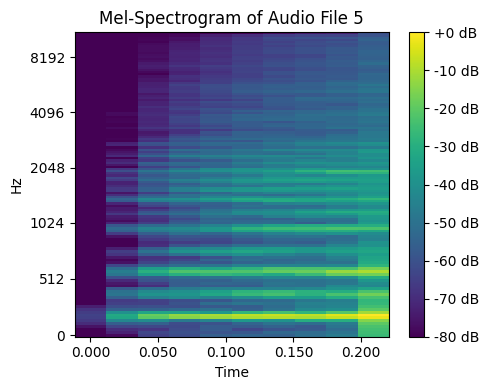

In [ ]:
# Plot MelSpectrogram for reference
mel_spectrogram = librosa.feature.melspectrogram(y=np.array(music_data[:5000]), sr=sr)
plt.figure(figsize=(5, 4))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                            y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram of Audio File {i}")
plt.tight_layout()
plt.show()


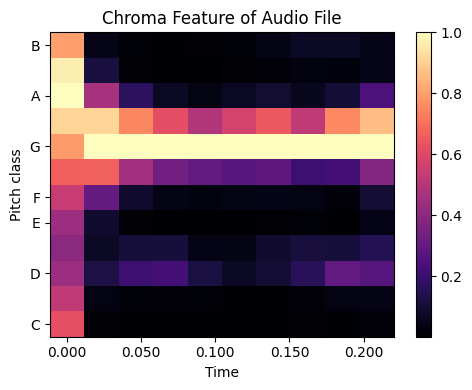

In [ ]:
# Plot for Chroma features
chroma = librosa.feature.chroma_stft(y=np.array(music_data[:5000]), sr=sr)
plt.figure(figsize=(5, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title(f"Chroma Feature of Audio File")
plt.tight_layout()
plt.show()

## Data preprocessing
Before feeding this into different neural networks, the data needs to be preprocessed.


All the files are first compiled and then split into X and y.

In [11]:
mel_spec = librosa.feature.melspectrogram(y = np.array(music_data), sr = sr, n_mels = 128) # Extract a melspectrogram of the audio data
db_mel_spec = librosa.power_to_db(mel_spec, ref = np.max) # Convert power to dB

spec_max = np.max(db_mel_spec) # Get max and min to help normalise the spectrogram
spec_min = np.min(db_mel_spec)
normalised_spec = (db_mel_spec - spec_min) / (spec_max - spec_min) # Normalise spectrogram
#normalised_spec = (normalised_spec * 2) - 1


In [12]:
seq_len = 256
X = []
#y = []
for i in range(sample):
  for j in range(0, len(normalised_spec[i])- seq_len, seq_len):
    X.append(normalised_spec[i][j : j + seq_len]) # SPlit data into sequences of length 256
    #y.append(normalised_spec[i][j + 1 : j + seq_len + 1])

X = np.array(X)
#y = np.array(y)

In [13]:
del(normalised_spec)
del(music_paths)
del(music_data)
del(db_mel_spec)
del(mel_spec) #Delete variables

In [14]:
train_size = 0.8
train_end = int(len(X) * train_size) # Split dataset into training and testing


# Split the data
X_train, X_test = X[:train_end], X[train_end:]
#y_train, y_test = y[:train_end], y[train_end:]


In [67]:
train_data = TensorDataset(torch.from_numpy(X_train))
test_data = TensorDataset(torch.from_numpy(X_test))


train_loader = DataLoader(train_data, batch_size = 32, shuffle = True, drop_last = True) # Make a dataloader for training and testing
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True, drop_last = True)

In [16]:
del(X) # Delete extra variables
del(y)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
class UnFlatten(nn.Module): # Unflatten linear input to pass to a convolutional layer
    def forward(self, input, size=256):
        return input.view(1, size, input.size(0))

# GRU-VAE :

A VAE with GRU is built.

In [ ]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, inp, hidden = 512, z = 256):
    super().__init__()

    self.mu = nn.Linear(hidden, z)
    self.sigma = nn.Linear(hidden, z)

    #self.z2h = nn.Linear(z, hidden)
    self.out = nn.GRU(input_size = hidden, hidden_size = inp, num_layers = 5, batch_first = True)#nn.Linear(hidden, inp)

    self.enc = nn.Sequential(
        #nn.Linear(inp, hidden),
        #nn.ReLU(),
        #nn.Linear(150, 100),
        #nn.ReLU(),
        #nn.Linear(100, hidden)
        nn.GRU(input_size = inp, hidden_size = hidden, num_layers = 5, batch_first = True)
    )

    self.dec = nn.Sequential(
        nn.Linear(z, hidden),
        #nn.ReLU(),
        #nn.Linear(64, 100),
        nn.ReLU(),
        #nn.Linear(100, 150),
        #nn.ReLU(),
        #nn.GRU(input_size = hidden, hidden_size = hidden, num_layers = 4, batch_first = True)
    )



  def encoder(self, x):
    hid_op, _ = self.enc(x)
    mu, sigma = self.mu(hid_op), self.sigma(hid_op)
    return mu, sigma

  def decoder(self, z):
    hid_op = self.dec(z)
    return torch.sigmoid(self.out(hid_op)[0])

  def forward(self, x):
    mu, sigma = self.encoder(x)
    epsilon = torch.randn_like(sigma)
    z_repar = mu + sigma*epsilon
    x_recon = self.decoder(z_repar)
    return x_recon, mu, sigma




In [ ]:
model = VariationalAutoEncoder(inp)
optimiser = torch.optim.Adam(model.parameters(), lr = 3e-6)

loss = nn.MSELoss()
num_epochs = 5

for epoch in range(num_epochs):
  loop = tqdm(enumerate(train_loader))

  for i,(x, _) in loop:
    x = x.to(device)
    x_recon, mu, sigma = model(x)
    x_recon_norm = (x_recon- x_recon.min())/(x_recon.max()- x_recon.min())
    recon_loss = loss(x_recon_norm, x)
    kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    comb_loss = recon_loss + kl
    optimiser.zero_grad()
    comb_loss.backward()
    optimiser.step()

    #scheduler.step()
    loop.set_postfix(loss = comb_loss.item())
    del(x)
    del(x_recon)
    del(comb_loss)
    del(kl)
    del(recon_loss)

In [ ]:
model.eval()
comb_test_loss = 0
with torch.no_grad():
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(test_loader))

    for i, (x, _) in loop:
        x = x.to(device)
        x_recon, mu, sigma = model(x)
        x_recon_norm = (x_recon - x_recon.min()) / (x_recon.max() - x_recon.min())
        recon_loss = loss(x_recon_norm, x)
        kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        comb_test_loss = kl + recon_loss
        loop.set_postfix(loss = comb_test_loss.item())
        del(x)
        del(x_recon)
        del(comb_test_loss)
        del(kl)
        del(recon_loss)



In [ ]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/GRUVAE_ver10.pth')
#del(model)

In [ ]:
import soundfile as sf

inference = VariationalAutoEncoder(2048)
inference.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/Models/GRUVAE_ver10.pth'))
inference.eval()

latent_code = torch.rand(6000, 512)

with torch.no_grad():
    norm_generated_spec = inference.decoder(latent_code)
    #del(inference)
    norm_generated_spec = np.array(norm_generated_spec.detach())

#norm_generated_spec = (norm_generated_spec + 1) * 0.5
generated_spec = np.array((norm_generated_spec * (spec_max - spec_min))+ spec_min)
generated_spec = librosa.db_to_power(generated_spec, ref = ref)



In [ ]:
generated_audio = librosa.feature.inverse.mel_to_audio(generated_spec, sr = sr, n_iter = 100)

In [ ]:
sf.write('/content/gdrive/MyDrive/kaggle/GeneratedSamples/GRUVAE_ver10_samp02.mp3', generated_audio, sr)

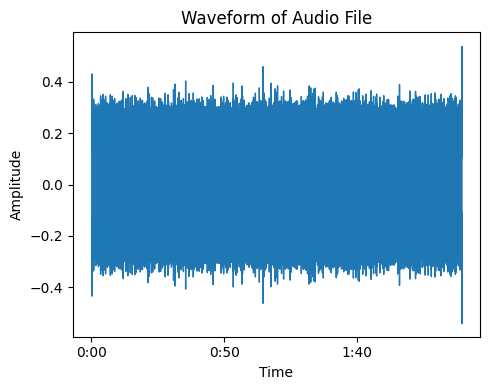

In [ ]:


plt.figure(figsize=(5, 4))
librosa.display.waveshow(generated_audio, sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

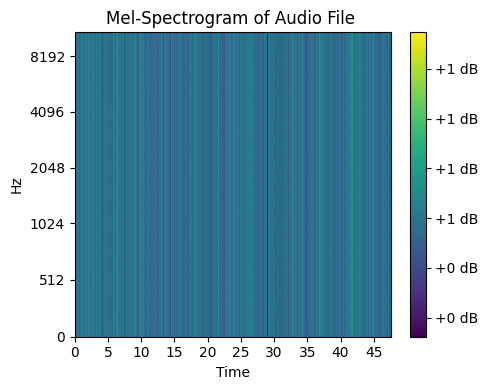

In [ ]:
plt.figure(figsize=(5, 4))
librosa.display.specshow(generated_spec,y_axis='mel', x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram of Audio File ")
plt.tight_layout()
plt.show()

#Conv - VAE
VAE with Convolutionals blocks is built.

In [ ]:
class ConvVAE(nn.Module):

  def __init__(self, inp, hidden = 512, z = 128):
    super().__init__()
    self.inp = inp
    self.z = z
    self.hidden = hidden
    self.HigherDim = nn.Linear(self.z, self.hidden)
    self.mu = nn.Linear(hidden, z)
    self.sigma = nn.Linear(hidden, z)

    self.EncoderLayer = nn.Sequential(

        nn.Conv1d(self.inp, 32, kernel_size = 3),
        nn.BatchNorm1d(254),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size = 3),
        nn.BatchNorm1d(252),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size = 3),
        nn.BatchNorm1d(250),
        nn.ReLU(),
        nn.Conv1d(128, 256, kernel_size = 3),
        nn.BatchNorm1d(248),
        nn.ReLU(),
        nn.Conv1d(256, 512, kernel_size = 3),
        nn.BatchNorm1d(246),
        #nn.ReLU(),
        ##nn.Conv1d(512, self.hidden, kernel_size = 3),
        #nn.BatchNorm1d(self.hidden),
        nn.ReLU(),
        nn.Flatten()
    )

    self.DecoderLayer = nn.Sequential(
        UnFlatten(),
        #nn.Linear(self.z, self.hidden),
        #nn.ConvTranspose1d(self.hidden, 512, kernel_size = 3),
        #nn.BatchNorm1d(512),
        #nn.LeakyReLU(0.2),
        #nn.ReLU(),
        nn.ConvTranspose1d(512, 256, kernel_size = 3),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.ConvTranspose1d(256, 128, kernel_size = 3),
        #nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.ConvTranspose1d(128, 64, kernel_size = 3),
        #nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.ConvTranspose1d(64, 32, kernel_size = 3),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.ConvTranspose1d(32, inp, kernel_size = 3),
        nn.BatchNorm1d(self.inp),
        nn.ReLU(),
        nn.Flatten()
    )

  def Encoder(self, inp):
    op1 = self.EncoderLayer(inp)
    mu, sigma = self.mu(op1.T), self.sigma(op1.T)
    return mu, sigma

  def Decoder(self, z):
    z = self.HigherDim(z)
    op = self.DecoderLayer(z)
    return nn.functional.hardtanh(op)

  def forward(self, inp):
    mu, sigma = self.Encoder(inp)
    epsilon = torch.randn_like(sigma)
    z_repar = mu + sigma * epsilon
    x_recon = self.Decoder(z_repar)
    return x_recon, mu, sigma


In [ ]:
model = ConvVAE(1)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr = 5e-3)
loss = nn.MSELoss()
num_epochs = 5

for epoch in range(num_epochs):
  loop = tqdm(enumerate(train_loader))

  for i,(x) in loop:
    x = x[0].to(device)
    x_recon, mu, sigma = model(x)
    recon_loss = loss(x_recon, x).to(device)
    kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    comb_loss = recon_loss + kl
    optimiser.zero_grad()
    comb_loss.backward()
    optimiser.step()
    loop.set_postfix(loss = comb_loss.item())
    del(x)
    del(x_recon)
    del(comb_loss)
    del(kl)
    del(recon_loss)

68it [00:05, 12.43it/s, loss=1.84]


KeyboardInterrupt: 

In [ ]:
model.eval()
comb_test_loss = 0
with torch.no_grad():
  for epoch in range(num_epochs):
    loop = tqdm(enumerate(test_loader))

    for i, (x, _) in loop:
        x = x.to(device)
        x_recon, mu, sigma = model(x)
        x_recon_norm = (x_recon - x_recon.min()) / (x_recon.max() - x_recon.min())
        recon_loss = loss(x_recon_norm, x)
        kl = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        comb_test_loss = kl + recon_loss
        loop.set_postfix(loss = comb_test_loss.item())
        del(x)
        del(x_recon)
        del(comb_test_loss)
        del(kl)
        del(recon_loss)




In [ ]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/ConvVAE_ver03.pth')
#del(model)

In [ ]:
import soundfile as sf

inference = ConvVAE(1)
inference.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/Models/ConvVAE_ver03.pth'))
inference.eval()

latent_code = torch.rand(6000, 128)

with torch.no_grad():
    norm_generated_spec = inference.Decoder(latent_code)
    #del(inference)
    norm_generated_spec = np.array(norm_generated_spec.detach())

#norm_generated_spec = (norm_generated_spec + 1) * 0.5
generated_spec = np.array((norm_generated_spec * (spec_max - spec_min))+ spec_min)
generated_spec = librosa.db_to_power(generated_spec, ref = 20)



In [ ]:
generated_audio = librosa.feature.inverse.mel_to_audio(generated_spec, sr = sr, n_iter = 20)

In [ ]:
sf.write('/content/gdrive/MyDrive/kaggle/GeneratedSamples/ConvVAE_ver03_samp02.mp3', generated_audio, sr)

In [ ]:
plt.figure(figsize=(5, 4))
librosa.display.waveshow(generated_audio, sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [ ]:
#mel_spectrogram = librosa.feature.melspectrogram(y=music_data[i], sr=sample_rate[i])
plt.figure(figsize=(5, 4))
mel_spec  = librosa.feature.melspectrogram(y = generated_audio, sr = sr)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref = np.max))
#plt.colorbar(format='%+2.0f dB')
#plt.title(f"Mel-Spectrogram of Audio File ")
plt.tight_layout()
plt.show()

# VAE - GAN :
A VAE-GAN is built.

In [25]:
class VAEEncoder(nn.Module):

  def __init__(self, inp, hidden = 256, z = 128):
    super().__init__()
    self.inp = inp
    self.z = z
    self.hidden = hidden
    self.mu = nn.Linear(self.hidden, self.z, bias = False)
    self.sigma = nn.Linear(self.hidden, self.z, bias = False)

    self.EncoderLayer = nn.Sequential(

        nn.Conv1d(self.inp, 32, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Conv1d(32, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Conv1d(128, 256, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Conv1d(256, 512, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Flatten()
    )

  def Encoder(self, x):
    op = self.EncoderLayer(x)
    mu = self.mu(op)
    sigma = self.sigma(op)
    kld = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    return mu, sigma, kld

  def forward(self, x):
    mu, sigma, kld = self.Encoder(x)
    epsilon = torch.randn_like(sigma)
    z_repar = mu + sigma * epsilon
    return z_repar, kld

In [31]:
class VAEDecoder(nn.Module):
  def __init__(self, inp, hidden = 256, z = 128):
    super().__init__()
    self.inp = inp
    self.z = z
    self.hidden = hidden
    self.HigherDim = nn.Linear(self.z, 256)

    self.DecoderLayer = nn.Sequential(
        nn.ConvTranspose1d(512, 256, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.ConvTranspose1d(256, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.ConvTranspose1d(128, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.ConvTranspose1d(64, 32, kernel_size = 3, padding = 1),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.ConvTranspose1d(32, self.inp, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.Flatten()
    )

  def forward(self, x):
    x = self.HigherDim(x)
    x_recon = self.DecoderLayer(x)
    return x_recon

In [64]:
class Discriminator(nn.Module):
  def __init__(self, input_channels, features = 128):
    super().__init__()

    self.input_channels = input_channels
    self.features = features

    self.disc = nn.Sequential(
        nn.Conv1d(self.input_channels, self.features, kernel_size = 4),
        nn.LeakyReLU(0.2),
        nn.Conv1d(self.features, self.features * 2, 5, stride = 2, padding = 1),
        nn.BatchNorm1d(self.features - 2),
        nn.LeakyReLU(0.2),
        nn.Conv1d(self.features * 2, self.features * 4, 5, stride = 2, padding = 1),
        nn.BatchNorm1d(62),
        nn.LeakyReLU(0.2),
        nn.Conv1d(self.features * 4, self.features * 8, 5, stride = 2, padding = 1),
        nn.BatchNorm1d(30),
        nn.LeakyReLU(0.2),
        nn.Conv1d(self.features * 8, self.features * 16, 5, stride = 2, padding = 1),
        nn.BatchNorm1d(14),
        nn.LeakyReLU(0.2),
    )
  def forward(self, x):
    return self.disc(x)

In [69]:
num_epochs = 1
learning_rate = 3e-4
gamma = 2
batch_size = 32

enc = VAEEncoder(batch_size).to(device)
enc_opt = torch.optim.Adam(enc.parameters(), lr = learning_rate)

dec = VAEDecoder(batch_size).to(device)
dec_opt = torch.optim.Adam(enc.parameters(), lr = learning_rate)

disc = Discriminator(batch_size)
disc_opt = torch.optim.Adam(disc.parameters(), lr = learning_rate)

loss = nn.MSELoss()


for epoch in range(num_epochs):
  loop = tqdm(enumerate(train_loader))
  for i, (x) in loop:
    x = x[0].to(device) # X
    Z, kld = enc(x) # Zreparametrized <- Enc(x), Lprior
    #Lprior = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
    Lprior = kld
    xt = dec(Z) # X~ <- Dec(Z)
    xt = (xt - xt.min())/ (xt.max() - xt.min())
    Ldis = loss(xt, x) # Ldis <- Loss due to dissimilarity
    Zp = torch.randn_like(Z) # Samples from Normal Distribution
    Xp = dec(Zp) # Xp <- Dec(Zp)

    # LGAN
    DisX = disc(x) # Dis(X)
    DisX_norm = (DisX - DisX.min()) / (DisX.max() - DisX.min())

    DisXt = disc(xt) # Dis(X~)
    DisXt_norm = (DisXt - DisXt.min()) / (DisXt.max() - DisXt.min())

    DisXp = disc(Xp) #Dis(Xp)
    DisXp_norm = (DisXp - DisXp.min()) / (DisXp.max() - DisXp.min())


    DisX_loss = loss(DisX_norm, torch.zeros_like(DisX_norm)) # log(Dis(X))
    DisXt_loss = loss(DisXt_norm, torch.ones_like(DisXt_norm)) # log(1 - Dis(X~))
    DisXp_loss = loss(DisXp_norm, torch.ones_like(DisXp_norm)) # log(1 - Dis(Xp))

    LGAN = DisX_loss + DisXt_loss + DisXp_loss # LGAN <- log(Dis(X)) + log(1 - Dis(X~)) + log(1 - Dis(Xp))

    encoder_loss = Lprior + Ldis
    decoder_loss = (gamma * Ldis) - LGAN
    discriminator_loss = LGAN

    #Backpropagating Losses
    enc_opt.zero_grad()
    dec_opt.zero_grad()
    disc_opt.zero_grad()
    encoder_loss.backward(retain_graph = True)
    decoder_loss.backward(retain_graph = True)
    discriminator_loss.backward()

    enc_opt.step()
    dec_opt.step()
    disc_opt.step()
    loss_dict = collections.OrderedDict([('Encoder Loss', encoder_loss.item()), ('Decoder Loss', decoder_loss.item()), ('Discriminator Loss', discriminator_loss.item())])
    loop.set_postfix(loss_dict)

136it [04:05,  1.81s/it, Encoder Loss=0.609, Decoder Loss=-0.773, Discriminator Loss=1.35]


In [70]:
torch.save(dec.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/VAEGAN_Decoder_ver03.pth')
torch.save(enc.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/VAEGAN_Encoder_ver03.pth')
torch.save(disc.state_dict(),'/content/gdrive/MyDrive/kaggle/Models/VAEGAN_Discriminator_ver03.pth')

In [72]:
import soundfile as sf

inference_dec = VAEDecoder(16)
inference_dec.load_state_dict(torch.load('/content/gdrive/MyDrive/kaggle/Models/VAEGAN_Decoder_ver02.pth'))
inference_dec.eval()

latent_code = torch.rand(512, 128)

with torch.no_grad():
    norm_generated_spec = inference_dec.forward(latent_code)
    del(inference_dec)
    norm_generated_spec = np.array(norm_generated_spec)

#norm_generated_spec = (norm_generated_spec + 1) * 0.5
generated_spec = np.array((norm_generated_spec * (spec_max - spec_min))+ spec_min)
#generated_spec = librosa.db_to_power(generated_spec, ref = 80)

In [73]:
generated_audio = librosa.feature.inverse.mel_to_audio(generated_spec, sr = sr, n_iter = 2)
#generated_audio = librosa.db_to_power(generated_audio, ref = 80)

In [74]:
from IPython.display import Audio, IFrame, display

display(Audio(generated_audio,rate=sr))

In [48]:
sf.write('/content/gdrive/MyDrive/kaggle/GeneratedSamples/VAEGAN_Generator_ver01_samp01.mp3', generated_audio, sr)

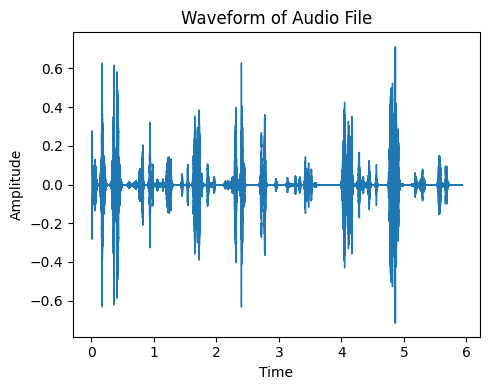

In [75]:
plt.figure(figsize=(5, 4))
librosa.display.waveshow(generated_audio, sr=sr)
plt.title(f"Waveform of Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

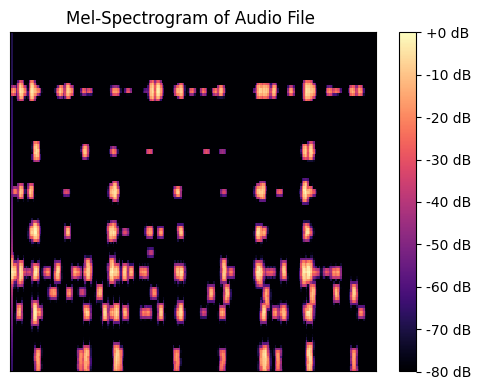

In [78]:
plt.figure(figsize=(5, 4))
mel_spec  = librosa.feature.melspectrogram(y = generated_audio, sr = sr)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref = np.max))
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel-Spectrogram of Audio File ")
plt.tight_layout()
plt.show()